In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os, argparse

# Read and clean the base dataset

In [30]:
processors = pd.read_excel('dataset/DataSetWithRelaventNodesArea.xlsx')
processors = processors.dropna(subset=['DieSizeValue', 'Die Size (mm^2)'], how='all')
processors = processors[(processors['DieSizeValue'] != 0) | (processors['Die Size (mm^2)'] != 0)]
processors = processors[processors['DieSizeValue'] != 'unknown']
processors = processors[processors['Die Size (mm^2)'] != 'unknown']
# Chiplet processors have different notations in die size value and die size
chiplet = processors[processors['DieSizeValue'] != processors['Die Size (mm^2)']]


processors = processors.drop(processors[processors['DieSizeValue'] != processors['Die Size (mm^2)']].index)
processors = processors[processors['TDP (W)'].notna()]
processors = processors[processors['TDP (W)'] != 'unknown']
processors = processors[processors['TDP (W)'] != '0']

# Probabilistic sequence generation
# All probability distribution is based on referenced tech reports
# sample_size is tunable, the resultant CFP values will not be significantly changed.

In [31]:
sample_size = 5
ci_model_mean = 522.936
ci_model_std = 19.826
Idle_time = np.linspace(0.1, 1, 10)
Life_time = np.linspace(0.5, 5, 10)
ci_model = np.random.choice(np.arange(480.8486,546.7014,2.057901), size=sample_size, replace=True, p = [0.03125,0.03125,0.03125,0.03125,0.01041667,0.01041667,0.01041667,0.01041663,0.01041667,
                                                                                                  0.01041667,0.01041667,0.01041667,0.01041667,0.01041667,0.01041667,
                                                                                                  0.01041667,0.04166667,0.04166667,0.04166667,0.04166667,
                                                                                                  0.02083333,0.02083333,0.02083333,0.02083333,0.0625,0.0625,
                                                                                                  0.0625,0.0625,0.0625,0.0625,0.0625,0.0625])
gpa_mean=150
gpa_std=30

gpa_model = np.random.normal(gpa_mean, gpa_std, sample_size)
gpa_model = np.clip(gpa_model,50,300)


Idle_time_mean = Idle_time.mean()
Life_time_mean = Life_time.mean()

defective_density_bench =  {"7": 0.2, "10": 0.11, "14":0.09, "22": 0.08, "28":0.07, "65":0.05}
epa_bench =  {"7": 2.15, "10": 1.475, "14":1.2, "22": 1.2, "28":0.9}

epa_distribution = [0.092478422,0.09864365,
                    0.101726264,0.103575832,0.101726264,0.097410604,
                    0.091245376,0.08323058,0.073982737,0.061652281,
                    0.048088779,0.033908755,0.012330456,]

defective_distribution=[0.1125,0.1125,0.1125,0.1125,0.1125,0.05,0.05,0.05,0.05,0.05,
    0.0125,0.0125,0.0125,0.0125,0.0125,0.0125,0.0125,0.0125,
    0.0125,0.0125,0.0125,0.0125,0.0125,0.0125,0.0125,]

def distribution_modeling(bench, p, stride = 25, d1 = None, d2 = None):
    d1 = 0.11 - 0.095
    d2 = 0.42 - 0.11
    defect_distribution = dict()
    for node in bench:
        defect_bench = defective_density_bench[node]
        start = defect_bench - d1
        end = defect_bench + d2
        step = (end - start) / stride
        defect_distribution[node] = np.random.choice(np.arange(start, end, step), size=sample_size, replace=True, p=p)

    return defect_distribution

def highest_probability(result):
    unique_values, counts = np.unique(result, return_counts=True)
    probabilities = counts / len(result)  # Convert frequenci_modeles to probabilities
    # Find the maximum probability and its corresponding value
    max_prob_index = np.argmax(probabilities)
    max_prob_value = unique_values[max_prob_index]
    max_prob = probabilities[max_prob_index]

    return max_prob_value, max_prob


In [32]:
defect_model = distribution_modeling(defective_density_bench, defective_distribution)
epa_model = distribution_modeling(epa_bench, epa_distribution, stride=13, d1 = 0.575, d2 = 0.025)

# Visualize the generated probability distribution

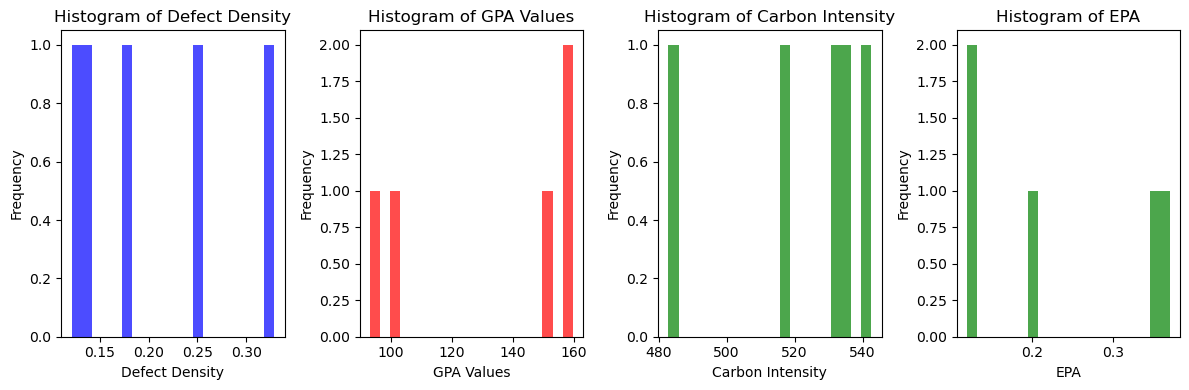

In [33]:
node = '10'
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.hist(defect_model[str(node)], bins=20, alpha=0.7, color='b')
plt.xlabel('Defect Density')
plt.ylabel('Frequency')
plt.title('Histogram of Defect Density')

# Plot histogram for gpa_model
plt.subplot(1, 4, 2)
plt.hist(gpa_model, bins=20, alpha=0.7, color='r')
plt.xlabel('GPA Values')
plt.ylabel('Frequency')
plt.title('Histogram of GPA Values')

# Plot histogram for ci_model
plt.subplot(1, 4, 3)
plt.hist(ci_model, bins=20, alpha=0.7, color='g')
plt.xlabel('Carbon Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Carbon Intensity')


plt.subplot(1, 4, 4)
plt.hist(epa_model[node], bins=20, alpha=0.7, color='g')
plt.xlabel('EPA')
plt.ylabel('Frequency')
plt.title('Histogram of EPA')

plt.tight_layout()
plt.show()

# CFP calculation and export CSV files

In [34]:
sys.path.append(os.path.join(os.getcwd(), "src"))

from eco_chip_func import eco_chip
for idx, proc in processors.iterrows():

    # node = int(proc['Process Size (nm)'])
    node = int(proc['Process Size (nm)'])
    power = int(proc['TDP (W)'])
    area = int(proc['DieSizeValue'])

    # print(node, power, area)

    defect_density = defect_model[str(node)].min()
    epa_val = epa_model[str(node)].min()
    gpa_val = gpa_model.min()
    ci_val = ci_model.min()

    args = argparse.Namespace(design_dir='testcases/CFP_survey/', 
                                chip_area=area, 
                                node=node, 
                                chip_power=power, 
                                defect_density=defect_density,
                                num_lifetime=None, 
                                gpa = gpa_val, 
                                epa = epa_val,
                                carbon_intensity=ci_val)    

    c_des, c_mfg, c_ope, c_tot = eco_chip(args)
    min_emb = float(c_des) + float(c_mfg)
    min_ope = c_ope
    min_tot = min_emb + float(c_ope)

    defect_density = defect_model[str(node)].max()
    epa_val = epa_model[str(node)].max()
    gpa_val = gpa_model.max()
    ci_val = ci_model.max()

    c_des, c_mfg, c_ope, c_tot = eco_chip(args)
    max_emb = float(c_des) + float(c_mfg)
    max_ope = c_ope
    max_tot = max_emb + float(c_ope)

    processors.at[idx, 'Emb Crabon Min'] = min_emb
    processors.at[idx, 'Ope Carbon Min'] = min_ope
    processors.at[idx, 'Tot Carbon Min'] = min_tot
    processors.at[idx, 'ECFPA Min'] = min_emb / area


    processors.at[idx, 'Emb Crabon Max'] = max_emb
    processors.at[idx, 'Ope Carbon Max'] = max_ope
    processors.at[idx, 'Tot Carbon Max'] = max_tot
    processors.at[idx, 'ECFPA Max'] = max_emb / area

print("CFP Process Finished")
# processors

CFP Process Finished


In [35]:
chiplet['Emb Crabon Min'] = 'Insuficient Data'
chiplet['Ope Carbon Min'] = 'Insuficient Data'
chiplet['Tot Carbon Min'] = 'Insuficient Data'
chiplet['ECFPA Min'] = 'Insuficient Data'

chiplet['Emb Crabon Max'] = 'Insuficient Data'
chiplet['Ope Carbon Max'] = 'Insuficient Data'  
chiplet['Tot Carbon Max'] = 'Insuficient Data'
chiplet['ECFPA Max'] = 'Insuficient Data'

combined_df = pd.concat([chiplet, processors], ignore_index=True)
combined_df.to_csv('dataset/CFP-Results.csv', index=True)

# Following code sneppts generate the probability CFP models for selected flagship processors. 
# 1 Latest model for both Desktop and Datacenter series

In [36]:
import time
import joblib
# Add the src directory to sys.path
sys.path.append(os.path.join(os.getcwd(), "src"))
from eco_chip_func import eco_chip
from CO2_func import *
import argparse
# sample_size = 3
processor = {"RTX 3090Ti": [10, 450, 628], "Intel Core i9-14900KF": [10, 125, 257]
        ,"A100-SXM": [7, 400, 826], "Intel Xeon Platinum 8380": [10, 270, 628]}

def process_chip(i, j, k, m):
    mfg_carbon = []
    ope_carbon = []
    tot_carbon = []
    des_carbon = []
    emb_carbon = []
    name = []
    for proc in processor:
        node = processor[proc][0]
        power = processor[proc][1]
        area = processor[proc][2]
        defect_density = defect_model[str(node)][i]
        epa_val = epa_model[str(node)][j]
        gpa_val = gpa_model[k]
        ci_val = ci_model[m]

        args = argparse.Namespace(design_dir='testcases/CFP_survey/', 
                                chip_area=area, 
                                node=node, 
                                chip_power=power, 
                                defect_density=defect_density,
                                num_lifetime=None, 
                                gpa = gpa_val, 
                                epa = epa_val,
                                carbon_intensity=ci_val)    

        c_des, c_mfg, c_ope, c_tot = eco_chip(args)
        mfg_carbon.append(c_mfg)
        ope_carbon.append(c_ope)
        tot_carbon.append(c_tot)
        des_carbon.append(c_des)
        emb_carbon.append(float(c_des) + float(c_mfg))

        name.append(proc)

        local_df = pd.DataFrame({'Processor': name, 
                                 'Mfg_Carbon': mfg_carbon,
                                 'Des_Carbon': des_carbon,
                                 'Emb_Carbon': emb_carbon,
                                 'Ope_Carbon': ope_carbon, 
                                 'Tot_Carbon': tot_carbon,
                                 'Iteration': f"{i} * {j} * {k} * {m}"})
        # print(f"Finished iteration {i} {j} {k} {m}")
    return local_df



In [37]:
# Launch the parallel processing
start = time.time()
results = joblib.Parallel(n_jobs=-1)(joblib.delayed(process_chip)(i, j, k, m) for i in range(sample_size) 
                                     for j in range(sample_size) 
                                     for k in range(sample_size) 
                                     for m in range(sample_size))

final_df = pd.concat(results, ignore_index=True)

end_time = time.time()  # End time for performance measurement
elapsed_time = end_time - start

print(f"Elapsed time for processing: {elapsed_time:.2f} seconds")

Elapsed time for processing: 1.09 seconds


# Visualizing the modeled results

In [38]:
import matplotlib.pyplot as plt

# Convert columns to numeric
def convert_and_plot(df, model):
    df['Emb_Carbon'] = pd.to_numeric(df['Emb_Carbon'])
    df['Ope_Carbon'] = pd.to_numeric(df['Ope_Carbon'])
    df['Tot_Carbon'] = pd.to_numeric(df['Tot_Carbon'])

    # Plot histogram for Mfg_Carbon
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    df['Emb_Carbon'].plot(kind='hist', bins=50, density=True, alpha=0.6, color='b')
    plt.xlabel('Emb_Carbon kgCO2e')
    plt.ylabel('Probability')
    plt.title(f'Emb_Carbon Histogram of {model}')
    
    plt.subplot(1, 3, 2)
    df['Ope_Carbon'].plot(kind='hist', bins=50, density=True, alpha=0.6, color='b')
    plt.xlabel('Ope_carbon kgCO2e')
    plt.ylabel('Probability')
    plt.title(f'OpeCarbon Histogram of {model}')

    # Plot histogram for Tot_Carbon
    plt.subplot(1, 3, 3)
    df['Tot_Carbon'].plot(kind='hist', bins=50, density=True, alpha=0.6, color='g')
    plt.xlabel('Tot_Carbon kgCO2e')
    plt.ylabel('Probability')
    plt.title(f'Tot_Carbon Histogram of {model}')

    plt.tight_layout()
    plt.savefig(f"plots/{model}-CFP-histogram.pdf")
    df.to_csv(f"dataset/{model}-CFP-histogram.csv")

    plt.show()

def merged_plot(final_df, processor):
    plt.figure(figsize=(15, 5))
    # Plot histogram for Mfg_Carbon
    plt.subplot(1, 3, 1)
    for model in processor:
        df = final_df[final_df['Processor'] == model].copy()
        df['Emb_Carbon'] = pd.to_numeric(df['Emb_Carbon'])
        df['Emb_Carbon'].plot(kind='hist', bins=50, density=True, alpha=0.6, label=model)
    plt.xlabel('Emb_Carbon kgCO2e')
    plt.ylabel('Probability')
    plt.title('Emb_Carbon Histogram')
    plt.legend()

    plt.subplot(1, 3, 2)
    for model in processor:
        df = final_df[final_df['Processor'] == model].copy()
        df['Ope_Carbon'] = pd.to_numeric(df['Ope_Carbon'])
        df['Ope_Carbon'].plot(kind='hist', bins=50, density=True, alpha=0.6, label=model)
    plt.xlabel('Ope_Carbon kgCO2e')
    plt.ylabel('Probability')
    plt.title('Ope_Carbon Histogram')
    plt.legend()

    # Plot histogram for Tot_Carbon
    plt.subplot(1, 3, 3)
    for model in processor:
        df = final_df[final_df['Processor'] == model].copy()
        df['Tot_Carbon'] = pd.to_numeric(df['Tot_Carbon'])
        df['Tot_Carbon'].plot(kind='hist', bins=50, density=True, alpha=0.6, label=model)
    plt.xlabel('Tot_Carbon kgCO2e')
    plt.ylabel('Probability')
    plt.title('Tot_Carbon Histogram')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"merged-probabilistic-histogram.pdf")
    plt.show()

# Write to PDF format

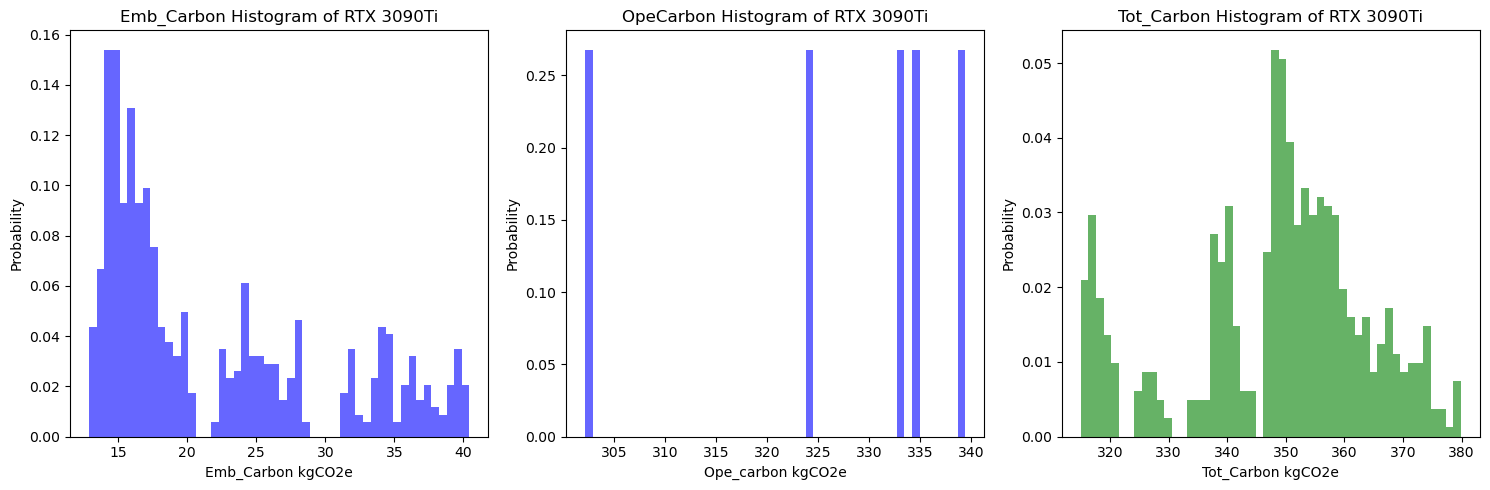

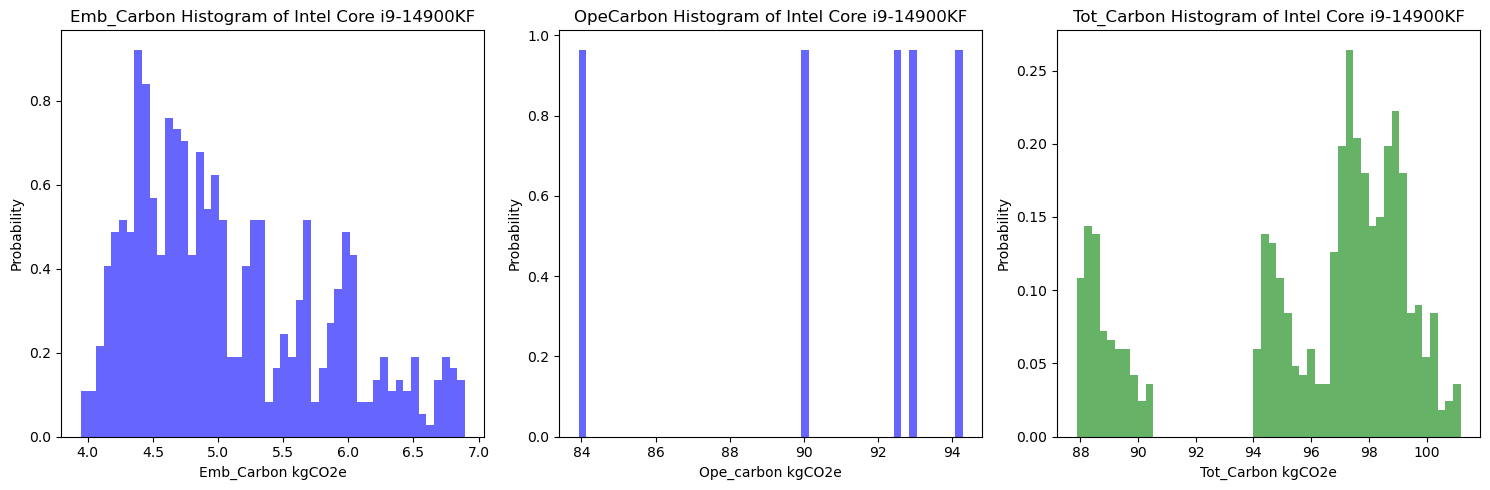

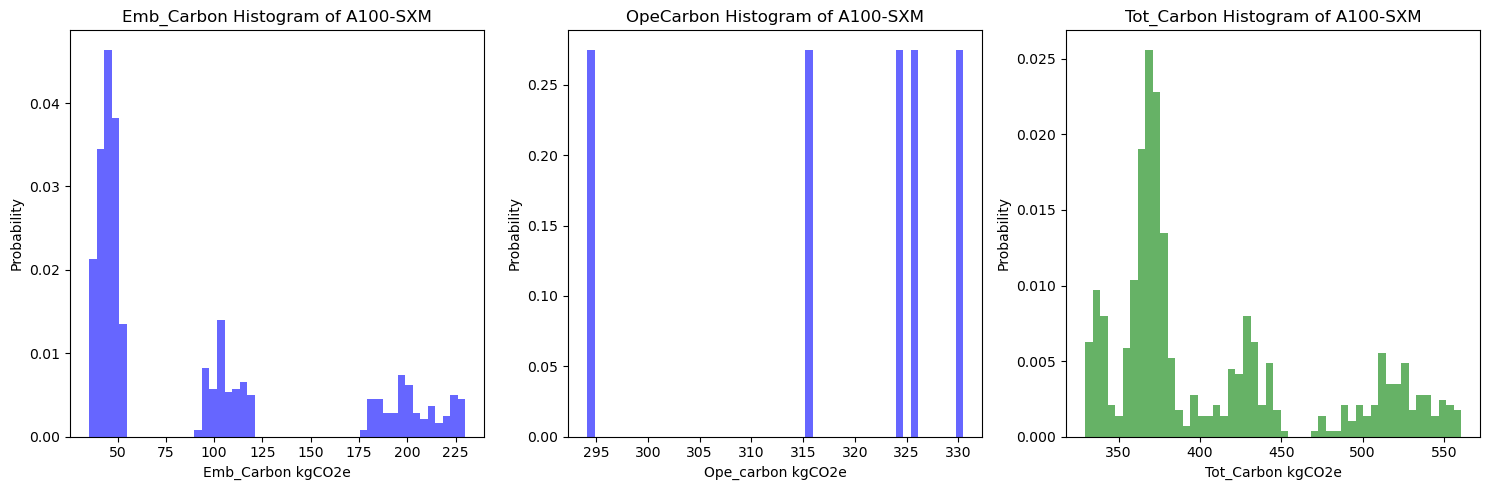

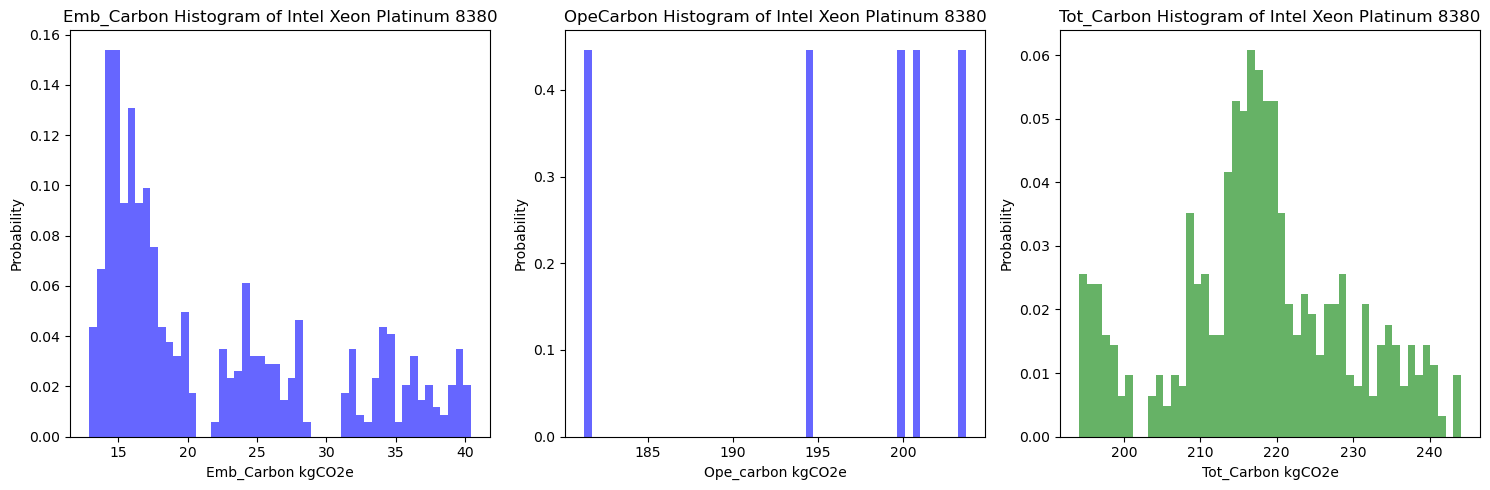

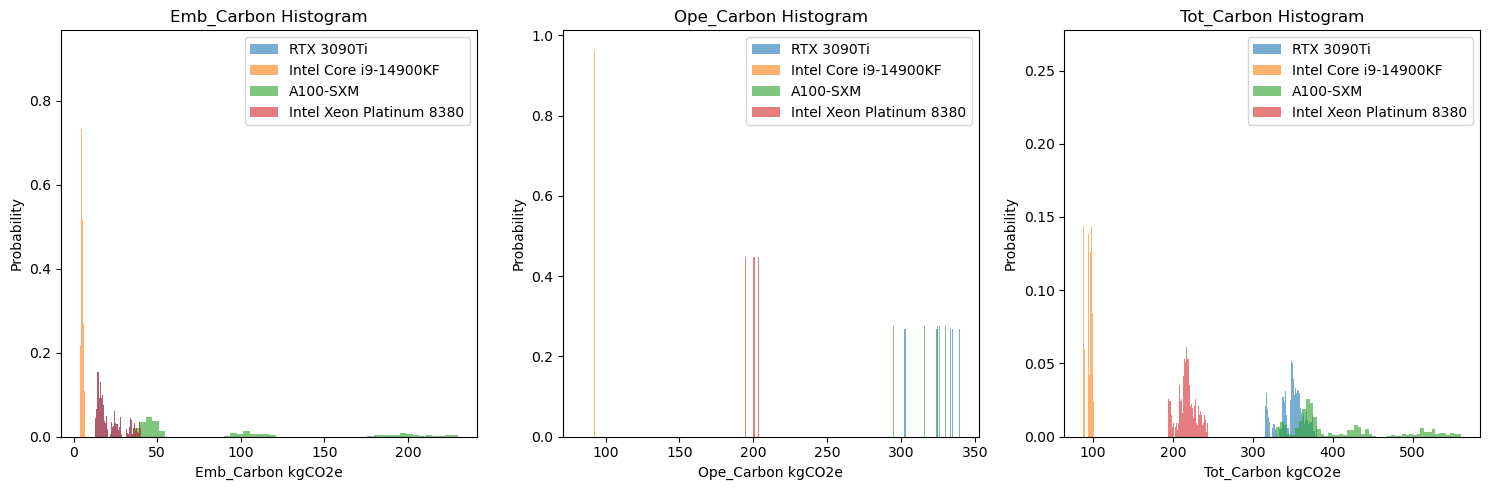

In [39]:
for model in processor:
    df = final_df[final_df['Processor'] == model].copy()
    convert_and_plot(df, model)
    
merged_plot(final_df, processor)

# Generate the lifetime scaled overall CFP for selected flagship processors

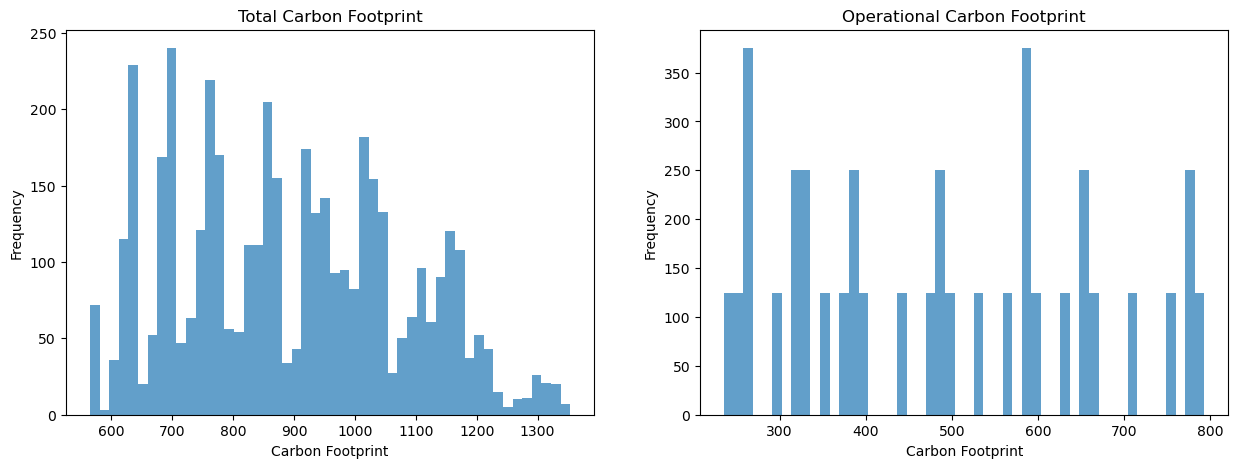

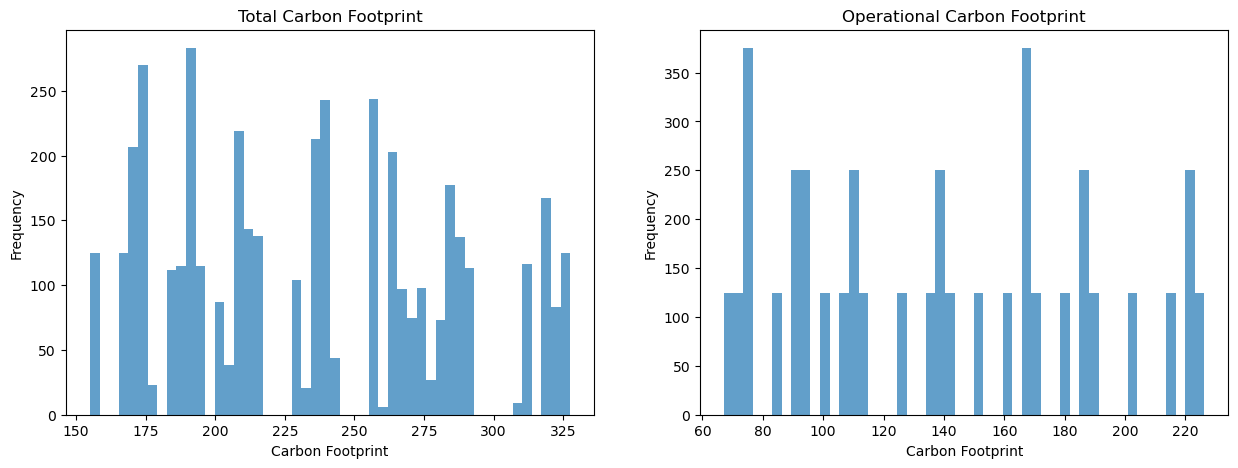

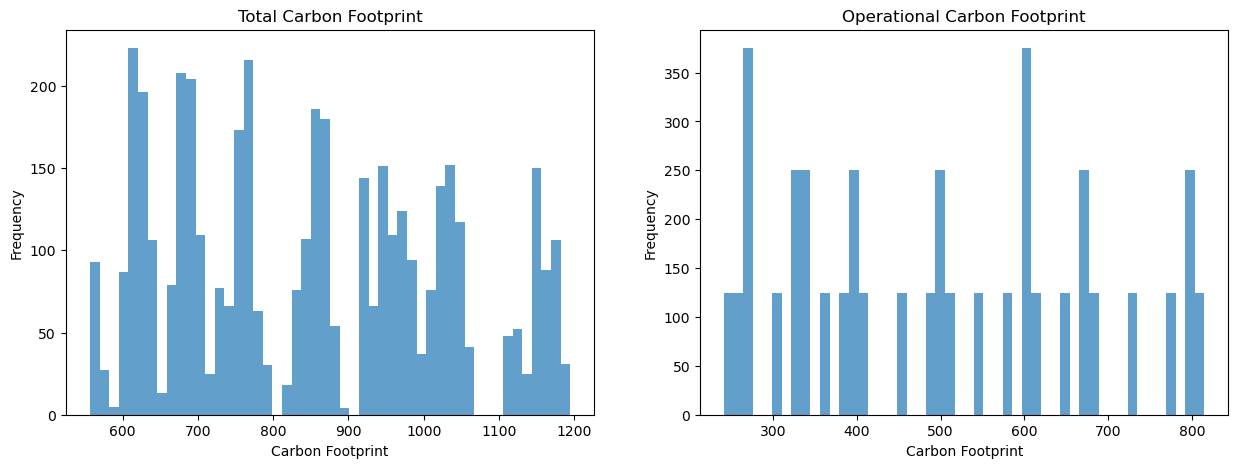

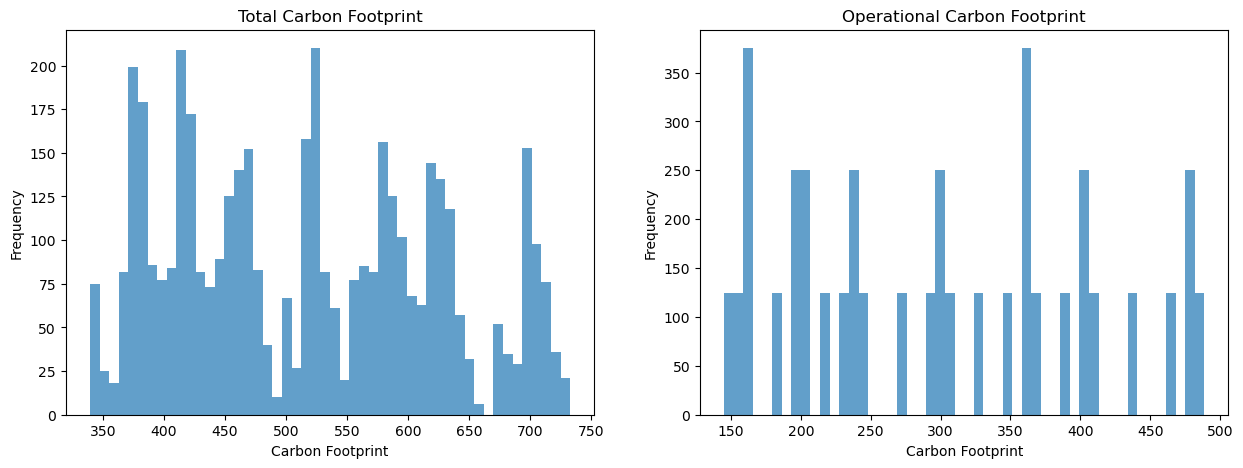

In [ ]:
processor = ['A100-SXM', 'Intel Core i9-14900KF', 'RTX 3090Ti', 'Intel Xeon Platinum 8380']
scaling_factors = [0.8, 1, 1.2, 1.5, 1.8, 2, 2.4]

for proc in processor:
    file_path = f'dataset/{proc}-CFP-histogram.csv'
    data = pd.read_csv(file_path)
    # data = data.drop(columns=['Iteration', 'Yield', 'EPA', 'GPA', 'Defect', 'CI', 'CPA'])
    ope_cfp = data['Ope_Carbon'].values.reshape(-1, 1) * scaling_factors
    tot_cfp = data['Tot_Carbon'].values.reshape(-1 ,1) + ope_cfp
    
    ope_cfp = pd.DataFrame(ope_cfp,columns=[f'scaled_{factor}' for factor in scaling_factors])
    tot_cfp = pd.DataFrame(tot_cfp, columns=[f'scaled_{factor}' for factor in scaling_factors])
    
    tot_cfp_combined = tot_cfp.values.flatten()
    ope_cfp_combined = ope_cfp.values.flatten()

    tot_cfp_combined = pd.DataFrame(tot_cfp_combined, columns=['Tot_Carbon'])
    ope_cfp_combined = pd.DataFrame(ope_cfp_combined, columns=['Ope_Carbon'])


    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.hist(tot_cfp_combined['Tot_Carbon'], bins=50, alpha=0.7)
    plt.title('Total Carbon Footprint')
    plt.xlabel('Carbon Footprint')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(ope_cfp_combined['Ope_Carbon'], bins=50, alpha=0.7)
    plt.title('Operational Carbon Footprint')
    plt.xlabel('Carbon Footprint')
    plt.ylabel('Frequency')

    plt.savefig(f"plots/{proc}-scaled-CFP.pdf")